In [1]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.lite as tflite
import tensorflow as tf

from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

## Freesound Instrument Challenge

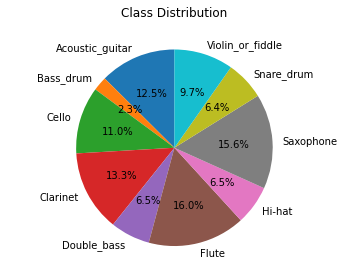

In [2]:
#clean_path = 'F:\\datasets\\freesound_instruments\\clean\\'
clean_path = 'clean\\'

df = pd.read_csv('instruments.csv')
df.set_index('fname', inplace=True)

for f in df.index:
    rate, signal = wavfile.read(clean_path+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [3]:
df.head()

label     length
fname                             
5388d14d.wav  Saxophone   4.140000
c685f05f.wav  Saxophone   1.540000
36d20ab5.wav  Saxophone   4.890562
d6665734.wav  Saxophone  10.165812
7352e28f.wav  Saxophone   6.240000

In [4]:
#get number of samples to draw from the audio files
n_samples = 2 * int(df['length'].sum()/0.1)
n_samples

26410

In [5]:
#total length of all the audio in the files
df.length.sum()

1320.5103125

In [6]:
#0 -1 class dist
prob_dist = class_dist / class_dist.sum()

#get a choice of instrument randomly based on class distribution
choices = np.random.choice(class_dist.index,p=prob_dist)

class_dist

label
Acoustic_guitar     5.523710
Bass_drum           1.028431
Cello               4.857862
Clarinet            5.872040
Double_bass         2.877908
Flute               7.040535
Hi-hat              2.847860
Saxophone           6.864981
Snare_drum          2.817537
Violin_or_fiddle    4.286144
Name: length, dtype: float64

## Make a CNN model

In [7]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16,(3,3),activation='relu',strides=(1,1),padding='same',input_shape=input_shape))
    model.add(Conv2D(32,(3,3),activation='relu',strides=(1,1),padding='same',input_shape=input_shape))
    model.add(Conv2D(64,(3,3),activation='relu',strides=(1,1),padding='same',input_shape=input_shape))
    model.add(Conv2D(128,(3,3),activation='relu',strides=(1,1),padding='same',input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(10,activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
    return model


## Generate data from cleaned files
Need to get random chunks of the data from the files.  These chunks here are 0.1s long and selected randomly from the distribution given above


In [11]:
nfilt=26
nfeat=13
nfft=512
rate=16000
step = int(rate/10)

#generate random sampling from dataset
def build_rand_feat():
    
    X = [];
    y=[]
    _min,_max = float('inf'),-float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index,p=prob_dist)   #get random instrument
        
        file = np.random.choice(df[df.label==rand_class].index)      #get random file based on random instrument
        
        rate,wav = wavfile.read(clean_path + file)                  #get the file
        
        label = df.at[file,'label']                                 #get the label for the file
        
        rand_index = np.random.randint(0,wav.shape[0] - step) #get random chunk from file
        
        sample = wav[rand_index:rand_index+step]              #get 0.1s from the audio file at random
        
        X_sample = mfcc(sample,rate,numcep=nfeat, nfilt = nfilt, nfft=nfft)
        
        _min = min(np.amin(X_sample),_min)                         #running update of min/max
        
        _max = max(np.amax(X_sample),_max)
        
        X.append(X_sample)
        
        y.append(classes.index(label))                             #get index number in the list for that instr(0-9)
    
    dataset_min = _min
    dataset_max = _max
        
    X, y = np.array(X),np.array(y)
    
    X = (X - _min)/ (_max - _min)
        
    X = X.reshape(X.shape[0],X.shape[1], X.shape[2],1) #samples * rows (time) * cols(mfccs) * white 

    y = to_categorical(y,num_classes=10)
    
    #config.data = (X,y)
    
    return X,y,dataset_min,dataset_max

In [13]:
#build dataset using distirbution we have defined
X,y,dataset_min,dataset_max = build_rand_feat()
y_flat = np.argmax(y,axis=1)      #get the max value across each row 
input_shape = (X.shape[1],X.shape[2],1)


100%|███████████████████████████████████████████████████████████████████████████| 26410/26410 [00:36<00:00, 722.87it/s]


In [14]:
model = get_conv_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 9, 13, 16)         160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 13, 32)         4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 13, 64)         18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 13, 128)        73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 6, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0

In [15]:
print(X.shape) # 26000 samples from the data
print(y.shape)

(26410, 9, 13, 1)
(26410, 10)


In [16]:
#base weights on prob dist defined above - need as unbalanced
class_weights = compute_class_weight(class_weight = "balanced",classes = np.unique(y_flat),
                                        y = y_flat )
class_weights = dict(zip(np.unique(y_flat), class_weights))
class_weights 

{0: 0.7811298432416445,
 1: 4.232371794871795,
 2: 0.9135247319266689,
 3: 0.7563001145475372,
 4: 1.5354651162790698,
 5: 0.6217043314500942,
 6: 1.5345729227193492,
 7: 0.6495327102803738,
 8: 1.5526161081716636,
 9: 1.029228371005456}

In [17]:
#checkpoint
filepath="weights.best.hdf5"

checkpoint = ModelCheckpoint(filepath,monitor='val_acc', 
                             verbose=2,mode='max',save_best_only=True,period=1)

In [18]:
model.fit(X,y,epochs=10,batch_size=32,shuffle=True,validation_split=0.1,callbacks=[checkpoint],verbose=2)

#model.save(config.model_path)

Epoch 1/10
743/743 - 9s - loss: 1.0122 - acc: 0.6359 - val_loss: 0.5262 - val_acc: 0.8243

Epoch 00001: val_acc improved from -inf to 0.82431, saving model to weights.best.hdf5
Epoch 2/10
743/743 - 8s - loss: 0.4713 - acc: 0.8360 - val_loss: 0.3342 - val_acc: 0.8819

Epoch 00002: val_acc improved from 0.82431 to 0.88186, saving model to weights.best.hdf5
Epoch 3/10
743/743 - 8s - loss: 0.3338 - acc: 0.8833 - val_loss: 0.2552 - val_acc: 0.9144

Epoch 00003: val_acc improved from 0.88186 to 0.91443, saving model to weights.best.hdf5
Epoch 4/10
743/743 - 8s - loss: 0.2600 - acc: 0.9060 - val_loss: 0.2428 - val_acc: 0.9148

Epoch 00004: val_acc improved from 0.91443 to 0.91480, saving model to weights.best.hdf5
Epoch 5/10
743/743 - 8s - loss: 0.2203 - acc: 0.9215 - val_loss: 0.2211 - val_acc: 0.9296

Epoch 00005: val_acc improved from 0.91480 to 0.92957, saving model to weights.best.hdf5
Epoch 6/10
743/743 - 8s - loss: 0.1906 - acc: 0.9331 - val_loss: 0.1906 - val_acc: 0.9409

Epoch 00006:

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\richard\AppData\Local\Temp\tmpruo2_u8d\assets


In [20]:
interpreter = tflite.Interpreter(model_path = "model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
input_index = input_details[0]['index']

output_details = interpreter.get_output_details()
output_index = output_details[0]['index']

## Making Predictions


In [34]:
def build_prediction(audio_dir,fn):

    fn_prob = {}

    rate,wav = wavfile.read(os.path.join(audio_dir,fn))

    label = fn2class[fn]
    print("The actual instrument type is {}".format(label))
    
    c = classes.index(label)
    y_prob = []
        
    for i in range(0,wav.shape[0]-step,step):
        sample = wav[i:i+step]
        x = mfcc(sample, rate, numcep=nfeat, nfilt=nfilt, nfft=nfft)
        x = (x - dataset_min) / (dataset_max - dataset_min)

        x = np.float32(x.reshape(1,x.shape[0],x.shape[1],1))
        interpreter.set_tensor(input_index,x)
        interpreter.invoke()
        y_hat = interpreter.get_tensor(output_index)
        y_prob.append(y_hat)

    fn_prob[fn] = np.mean(y_prob,axis=0).flatten()
        
    return fn_prob
    

In [41]:
df = pd.read_csv('instruments.csv')
classes = list(np.unique(df.label))
fn2class = dict(zip(df.fname,df.label))

fn_prob = build_prediction("clean","b6cbc6a9.wav")

prob_values = (list(fn_prob.values())[0])

max_index = np.argmax(prob_values)

print("The predicted instrument type is {}\n".format(classes[max_index]))

print(fn_prob)


The actual instrument type is Snare_drum
The predicted instrument type is Snare_drum

{'b6cbc6a9.wav': array([1.01025566e-04, 1.13290169e-10, 6.25292523e-05, 2.36683854e-06,
       8.45002912e-09, 5.82340799e-05, 1.58650948e-06, 6.79037767e-04,
       9.90221322e-01, 8.87385290e-03], dtype=float32)}
